Load Libraries

In [1]:
import numpy as np
import pandas as pd
import os.path as op
import spacy
nlp = spacy.load('en')

Load Data

In [2]:
DATA_PROCESSED = '../data/processed'

In [3]:
labeled = pd.read_csv(op.join(DATA_PROCESSED, 'labeled.csv'))
all_projects = pd.read_csv(op.join(DATA_PROCESSED, 'gofundme_projects.csv'))

In [4]:
labeled = labeled.loc[labeled['project_id'].isin(all_projects['id'])]

# Simpson's Index of Diversity

In [ ]:
kw = np.array([1,1,1])

tot = sum(kw * (kw-1))
print(1 - tot / (sum(kw) * (sum(kw) - 1)))

kw = np.array([1,0,1])

tot = sum(kw * (kw-1))
print(1 - tot / (sum(kw) * (sum(kw) - 1)))

In [ ]:
# will create a dataframe with project ID, and measures of productivity for battle and journey
productivities = []

# group by id
for i, g in labeled.groupby('project_id'):
    # get the number of words total for the project text
    all_words = all_projects.loc[all_projects['id'] == i, 'text_length_words']
    
    # some (~20) projects don't have data on text body size... potential bug
    if all_words.size > 0 and all_words.values[0] > 0:
        
        # battle productivity
        kw = g.loc[g['type'] == 'battle', 'keyword'].value_counts().values
#         kw = np.append(kw, all_words.values[0])

        # compute Simpson's Index of Diversity
        #     sum n(n - 1) 
        tot = sum(kw * (kw-1))
        if sum(kw) > 0:
            battle_div = tot / (sum(kw) * (sum(kw) - 1))
        else:
            battle_div = 0.0
        
        # journey productivity
        kw = g.loc[g['type'] == 'journey', 'keyword'].value_counts().values
#         kw = np.append(kw, all_words.values[0])

        # compute Simpson's Index of Diversity
        tot = sum(kw * (kw-1))
        if sum(kw) > 0:
            journey_div = tot / (sum(kw) * (sum(kw) - 1))
        else:
            journey_div = 0.0
        
    else:
        battle_div, journey_div = 0.0, 0.0
        
    productivities.append([i, battle_div, journey_div])
    
productivities = pd.DataFrame(productivities, columns=['id', 'battle_prod', 'journey_prod'])

Top projects by productivity, after looking at the text of these projects, the measure seems like an accurate representation of diversity in metaphor instantiation.

In [ ]:
productivities.nlargest(10, 'battle_prod')

An example project:

In [ ]:
all_projects.loc[all_projects['id'] == 1665364667, :]

In [ ]:
labeled.loc[labeled['project_id'] == 1665364667]

Create a copy (so as to not affect the original) and merge

In [ ]:
all_projects_c = all_projects.copy(deep=True)

In [ ]:
all_projects_c = all_projects_c.merge(productivities, how='left', on='id', validate='one_to_one')

It looks like our measures of diversity are highly correlated with salience:

In [ ]:
np.corrcoef(all_projects_c[['battle_prod', 'journey_prod', 'battle_salience', 'journey_salience']], rowvar=False)

# Custom Productivity

Let $C$ be the set of keyword counts over all projects. Each keyword appears $C_i \gt 0$ times, such that $i=1, 2, ..., N$ where $N$ is the number of unique keywords in the corpus.

Let $W$ be the set of keyword counts for a given project, where $W_i \geq 0$ for $i=1, 2, ..., N$. $C_i$ and $W_i$ represent the same keyword.

Productivity for each keyword family of a given project is:
$$
P_{\text{family}} = \sum_{i=1}^N W_i \times \big(\frac{\sum_{k=1}^N C_k}{C_i}\big)^r
$$
where $r$ is some proportionality constant.

In the following work, $r=0.4$ because this results in the least frequent word, *enemy*, becoming the "equivalent" (in terms of how creative we perceive its usage) to about 8 usages of the most frequent word, *fight*. This number is partially arbitrary and can be changed as seen fit. The frequency proportion (the value raised to $r$) is divided by the minimum of the set of frequency proportions, thereby forcing the most frequent word to have a frequency proportion of 1.0.



In [5]:
battle_vc = labeled.dropna().loc[(labeled['type'] == 'battle') & (labeled['metaphorical'] == True), 'keyword'].value_counts()
journey_vc = labeled.dropna().loc[(labeled['type'] == 'journey')& (labeled['metaphorical'] == True), 'keyword'].value_counts()

# print(battle_vc)

r = 0.4

battle_freq_map = (sum(battle_vc) / battle_vc) ** r
battle_freq_map = dict(battle_freq_map / min(battle_freq_map))

journey_freq_map = (sum(journey_vc) / journey_vc) ** r
journey_freq_map = dict(journey_freq_map / min(journey_freq_map))

print(battle_freq_map)
print(journey_freq_map)


{'fight': 1.0, 'battle': 1.229158512685047, 'fighting': 1.4377593500395272, 'beat': 1.6811389359792683, 'battling': 2.018701998502793, 'fought': 2.7369962496283278, 'win': 2.8853092224044503, 'beating': 3.2045695731754025, 'fights': 3.2942381636628055, 'battled': 3.8268894194389174, 'battles': 3.888208231480954, 'defeat': 4.786974705308483, 'beaten': 5.579479694098934, 'winning': 6.100391489864418, 'war': 6.316450992324286, 'beats': 7.002653455522158, 'enemy': 8.049514829687741}
{'journey': 1.0, 'road': 2.3872497410557854, 'path': 2.6752333020574484, 'travel': 15.817186386761122}


In [72]:
# will create a dataframe with project ID, and measures of productivity for battle and journey
productivities = []

c = 0

# group by id
for i, g in labeled.loc[labeled['metaphorical'].fillna(False)].groupby('project_id'):
    # get the number of words total for the project text
    all_words = all_projects.loc[all_projects['id'] == i, 'text_length_words']
    
    kw = g.loc[g['type'] == 'battle', 'keyword'].value_counts()
    s = [battle_freq_map[k] * kw[k] for k in dict(kw)]
    battle_div = sum(s)

    kw = g.loc[g['type'] == 'journey', 'keyword'].value_counts()
    s = [journey_freq_map[k] * kw[k] for k in dict(kw)]
    journey_div = sum(s)
        
    productivities.append([i, battle_div, journey_div])
    
productivities = pd.DataFrame(productivities, columns=['id', 'battle_prod', 'journey_prod'])

In [73]:
all_projects_c = all_projects.copy(deep=True)
all_projects_c = all_projects_c.merge(productivities, how='left', on='id', validate='one_to_one')
all_projects_c['battle_prod_y'] = all_projects_c['battle_prod_y'].fillna(0)
all_projects_c['journey_prod_y'] = all_projects_c['journey_prod_y'].fillna(0)

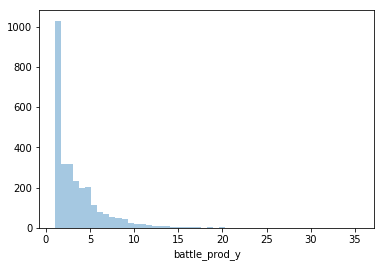

In [75]:
import seaborn as sns
sns.distplot(all_projects_c.loc[all_projects_c['battle_prod_y'] > 0, 'battle_prod_y'].dropna(), kde=False)

In [76]:
all_projects_c.nlargest(6, 'journey_prod_y')[['id', 'name', 'url', 'battle_prod_y', 'journey_prod_y']]

,id,name,url,battle_prod_y,journey_prod_y
6413,41a26131e9dc8e5974506affe5709099,Donna's Healing Journey,https://www.gofundme.com/donnashealingjourney,7.987859,9.000000
1195,d2822c53ff35826317b245e14ff98832,Lara's Heal Breast Cancer Fund,https://www.gofundme.com/larashealbreastcancer...,0.000000,7.659609
198,352d6883409cd7234eeca26599abeb21,Laura Studer's Answer To Cancer,https://www.gofundme.com/laura-studer039s-answ...,4.861777,7.319218
7086,c9b0511c2c378619c869a16ad791299c,Sue's Fight to Beat Cancer,https://www.gofundme.com/sues-fight-to-beat-ca...,4.180024,7.319218
1212,2db9397665633bf8e5546208fe3328c5,Shelly's Breast Cancer Fight,https://www.gofundme.com/pt5mh6-kick-breast-ca...,5.561235,6.659609
1473,cfd3ec6d08e07aa9cbb417075e2e30cc,Beth's Breast Cancer Recovery Fund,https://www.gofundme.com/bethboyd,1.231038,6.659609


In [62]:
labeled.loc[labeled['project_id'] == '352d6883409cd7234eeca26599abeb21']

,char_location,fragment,keyword,kw_start,metaphorical,project_id,type
6957,843.0,grace as she pursues it without complaint. ...,beating,81.0,True,352d6883409cd7234eeca26599abeb21,battle
6958,4657.0,"ueprint for how to proceed, and instilled a co...",beat,81.0,True,352d6883409cd7234eeca26599abeb21,battle
6959,714.0,an extremely strong and intuitive will. When s...,path,81.0,True,352d6883409cd7234eeca26599abeb21,journey
6960,964.0,"rtunately, the cancer has returned. This time...",path,81.0,True,352d6883409cd7234eeca26599abeb21,journey
6961,473.0,if it reoccurred in the future. If yo...,journey,81.0,True,352d6883409cd7234eeca26599abeb21,journey
6962,14894.0,"ales from the road, and invite you all to come...",journey,81.0,True,352d6883409cd7234eeca26599abeb21,journey
